# Call sites of "strong escape"
This Python Jupyter notebook call sites of srong escape from each antibody / sera

Import Python modules:

In [1]:
import os

from dms_variants.constants import CBPALETTE

from IPython.display import display, HTML

import pandas as pd

from plotnine import *

import yaml

Versions of key software:

Read the configuration file:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Create output directory:

In [3]:
os.makedirs(config['escape_profiles_dir'], exist_ok=True)

Extract from configuration what we will use as the site- and mutation-level metrics:

In [4]:
site_metric = config['site_metric']
mut_metric = config['mut_metric']

print(f"At site level, quantifying selection by {site_metric}")
print(f"At mutation level, quantify selection by {mut_metric}")

At site level, quantifying selection by site_total_escape_frac_single_mut
At mutation level, quantify selection by mut_escape_frac_single_mut


Read the escape fractions.
We only retain the **average** of the libraries for plotting here, not the individual libraries.
Also, we work in the full-Spike rather than RBD numbering, which means we use `label_site` as `site` (and so rename as such below):

In [5]:
print(f"Reading escape fractions from {config['escape_fracs']}")
escape_fracs = (pd.read_csv(config['escape_fracs'])
                .query('library == "average"')
                .drop(columns=['site', 'selection', 'library'])
                .rename(columns={'label_site': 'site'})
                )
print('First few lines of escape-fraction data frame with sample-information added:')
display(HTML(escape_fracs.head().to_html(index=False)))

Reading escape fractions from results/escape_scores/escape_fracs.csv
First few lines of escape-fraction data frame with sample-information added:


condition,site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_single_mut,site_total_escape_frac_single_mut,site_avg_escape_frac_single_mut,nlibs,n_single_mut_measurements
ADI-75586_64,331,N,A,E,331,0.024090,0.1507,0.01004,2,26
ADI-75586_64,331,N,D,E,331,0.007962,0.1507,0.01004,2,32
ADI-75586_64,331,N,E,E,331,0.009505,0.1507,0.01004,2,29
ADI-75586_64,331,N,G,E,331,0.007674,0.1507,0.01004,2,30
ADI-75586_64,331,N,H,E,331,0.008268,0.1507,0.01004,2,27


Now identify sites of "strong" selection using three criteria for each threshold.

 1. The selection at a site has to exceed the median selection across all sites for that condition (e.g., antibody or sera) by some threshold.
 
 2. The selection at a site has to be greater than some fraction of the maximum selection observed at any site for that condition (e.g., antibody or sera).
 
 3. The selection at a site has to exceed some absolute minimum.

In [6]:
site_threshold_df = pd.DataFrame()

for threshold, params in config['strong_escape_sites_calling_params'].items():
    print(f"\nCalling sites of strong escape for the {threshold} calling parameters:")
    
    exceed_median = params['exceed_median']
    frac_max = params['frac_max']
    min_value = params['min_value']

    print(f"Here are criteria used to call sites of strong escape for the {threshold} params:\n"
          f"  1. Selection at site exceeds median by >{exceed_median} fold\n"
          f"  2. Selection at site is >{frac_max} of the max for any site\n"
          f"  3. Selection at site is >{min_value}")
    
    if 'min_value_mut' in params:
        min_value_mut = params['min_value_mut']
        print(f"Sites are also called as significant if they have **any** mutation with escape fraction > {min_value_mut}")
    else:
        min_value_mut = None
    
    site_threshold_df = site_threshold_df.append(
        escape_fracs
        .assign(max_mut=lambda x: x.groupby(['condition', 'site'])[mut_metric].transform('max'))
        [['condition', 'site', site_metric, 'max_mut']]
        .drop_duplicates()
        .assign(
            threshold=threshold,
            median=lambda x: x.groupby('condition')[site_metric].transform('median'),
            max=lambda x: x.groupby('condition')[site_metric].transform('max'),
            exceed_median=lambda x: x['median'] * exceed_median,
            meet_exceed_median=lambda x: x[site_metric] > x['exceed_median'],
            frac_max=lambda x: x['max'] * frac_max,
            meet_frac_max=lambda x: x[site_metric] > x['frac_max'],
            min_value=lambda x: min_value,
            meet_min_value=lambda x: x[site_metric] > x['min_value'],
            meet_mut_min_value=lambda x: False if min_value_mut is None else x['max_mut'] > min_value_mut,
            strong_site=lambda x: (x['meet_exceed_median'] & x['meet_frac_max'] & x['meet_min_value']) | x['meet_mut_min_value'],
            n_strong_sites=lambda x: x.groupby('condition')['strong_site'].transform('sum'),
            )
        )
                    
# orders for plotting
site_threshold_df = (
        site_threshold_df
        .assign(condition=lambda x: pd.Categorical(x['condition'],
                                                   reversed(x['condition'].unique()),
                                                   ordered=True),
                )
        )


Calling sites of strong escape for the default calling parameters:
Here are criteria used to call sites of strong escape for the default params:
  1. Selection at site exceeds median by >10 fold
  2. Selection at site is >0.1 of the max for any site
  3. Selection at site is >0

Calling sites of strong escape for the sensitive calling parameters:
Here are criteria used to call sites of strong escape for the sensitive params:
  1. Selection at site exceeds median by >5 fold
  2. Selection at site is >0.05 of the max for any site
  3. Selection at site is >0

Calling sites of strong escape for the sensitive_max_mut calling parameters:
Here are criteria used to call sites of strong escape for the sensitive_max_mut params:
  1. Selection at site exceeds median by >5 fold
  2. Selection at site is >0.05 of the max for any site
  3. Selection at site is >0
Sites are also called as significant if they have **any** mutation with escape fraction > 0.5


/loc/scratch/60308138/ipykernel_17133/821032434.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/loc/scratch/60308138/ipykernel_17133/821032434.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/loc/scratch/60308138/ipykernel_17133/821032434.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Now plot the selection for all sites for all conditions, indicating which sites are strong escape and using lines to draw the three thresholds:

/fh/fast/bloom_j/computational_notebooks/tstarr/2022/SARS-CoV-2-RBD_Omicron_MAP_Adimab/env/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/fh/fast/bloom_j/computational_notebooks/tstarr/2022/SARS-CoV-2-RBD_Omicron_MAP_Adimab/env/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/fh/fast/bloom_j/computational_notebooks/tstarr/2022/SARS-CoV-2-RBD_Omicron_MAP_Adimab/env/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/fh/fast/bloom_j/computational_notebooks/tstarr/2022/SARS-CoV-2-RBD_Omicron_MAP_Adimab/env/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is depr

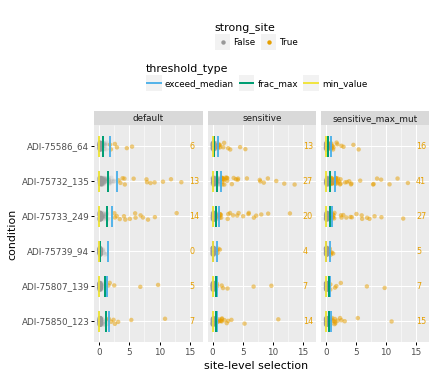

In [7]:
max_sel = site_threshold_df[site_metric].max()  # max y-value plotted

p = (ggplot(site_threshold_df.assign(alpha=lambda x: x['strong_site'].astype(int))) +
     aes(site_metric, 'condition', alpha='alpha', fill='strong_site') +
     geom_jitter(size=2.5, height=0.1, width=0, stroke=0, random_state=1) +
     scale_fill_manual(values=CBPALETTE) +
     scale_alpha(range=(0.15, 0.5), guide=None) +
     theme(figure_size=(4 * site_threshold_df['threshold'].nunique(),
                        0.25 * site_threshold_df['condition'].nunique()),
           legend_position='top',
           ) +
     xlab('site-level selection') +
     expand_limits(x=1.2 * max_sel) +
     geom_text(data=site_threshold_df[['condition', 'threshold', 'n_strong_sites']].drop_duplicates(),
               mapping=aes(y='condition', label='n_strong_sites'),
               inherit_aes=False,
               x=1.1 * max_sel,
               color=CBPALETTE[1],
               alpha=1,
               size=8,
               ha='left',
               va='center',
               ) +
     geom_linerange(data=site_threshold_df
                         .melt(id_vars=['condition', 'threshold'],
                               value_vars=['exceed_median', 'frac_max', 'min_value'],
                               var_name='threshold_type',
                               value_name='threshold_line')
                         .reset_index()
                         .drop_duplicates()
                         .assign(ymin=lambda x: x['condition'].cat.codes + 1 - 0.3,
                                 ymax=lambda x: x['condition'].cat.codes + 1 + 0.3),
                   mapping=aes(x='threshold_line', ymin='ymin', ymax='ymax', color='threshold_type'),
                   inherit_aes=False,
                   size=0.1) +
     scale_color_manual(values=CBPALETTE[2: ]) +
     facet_wrap('~ threshold', nrow=1)
     )

_ = p.draw()

Now get the strong sites for each condition, and write to a CSV file:

In [8]:
strong_sites = site_threshold_df.query('strong_site').reset_index(drop=True)

print('Number of sites of strong escape for each threshold:')
display(HTML(
    strong_sites
    .groupby('threshold')
    .aggregate(n_sites=pd.NamedAgg('site', 'nunique'))
    .to_html()
    ))

print(f"Writing to {config['strong_escape_sites']}, and printing the first few lines below:")
display(HTML(strong_sites.head().to_html()))

strong_sites.to_csv(config['strong_escape_sites'], index=False)

Number of sites of strong escape for each threshold:


,n_sites
threshold,
default,26
sensitive,41
sensitive_max_mut,55


Writing to results/escape_profiles/strong_escape_sites.csv, and printing the first few lines below:


,condition,site,site_total_escape_frac_single_mut,max_mut,threshold,median,max,exceed_median,meet_exceed_median,frac_max,meet_frac_max,min_value,meet_min_value,meet_mut_min_value,strong_site,n_strong_sites
0,ADI-75586_64,344,4.568,0.8179,default,0.17505,5.44,1.7505,True,0.544,True,0,True,False,True,6
1,ADI-75586_64,348,5.440,0.8332,default,0.17505,5.44,1.7505,True,0.544,True,0,True,False,True,6
2,ADI-75586_64,352,2.585,0.7933,default,0.17505,5.44,1.7505,True,0.544,True,0,True,False,True,6
3,ADI-75586_64,354,2.926,0.8125,default,0.17505,5.44,1.7505,True,0.544,True,0,True,False,True,6
4,ADI-75586_64,356,1.776,0.7549,default,0.17505,5.44,1.7505,True,0.544,True,0,True,False,True,6


Plot which sites are auto-identified for each condition (e.g., antibody or sera):

/fh/fast/bloom_j/computational_notebooks/tstarr/2022/SARS-CoV-2-RBD_Omicron_MAP_Adimab/env/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


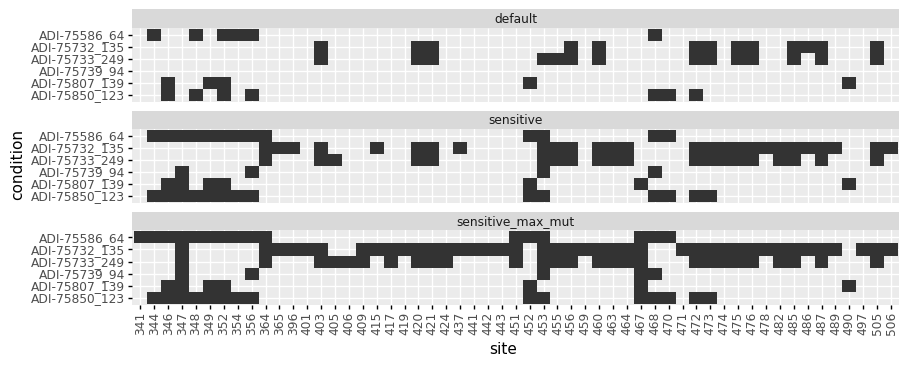

In [9]:
p = (ggplot(strong_sites
            .assign(site=lambda x: pd.Categorical(x['site'],  # categorical so only plot observed sites
                                                  sorted(x['site'].unique()),
                                                  ordered=True)
                    )
            ) +
     aes('site', 'condition') +
     geom_tile() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.18 * strong_sites['site'].nunique(),
                        0.2 * strong_sites['condition'].nunique() * strong_sites['threshold'].nunique()),
           ) +
     facet_wrap('~ threshold', ncol=1)
     )

_ = p.draw()